<h1><center>ResNet-50识别岩石样本</center></h1>

In [1]:
# 导包
#import tensorflow.compat.v1 as tf
my_seed = 520
# 导包
import os
os.environ['PYTHONHASHSEED'] = str(my_seed)

import numpy as np
import random 
import tensorflow as tf

# 设置随机种子，保证可复现, 随机种子的设置要在任何一次使用到随机数前设置，因此通常在刚导入完所有包后立即设置。提示：后续的解决样本不平衡过程。
np.random.seed(my_seed)
random.seed(my_seed)
# tf.random.set_seed(my_seed)

import keras as K
from keras import backend
import pandas as pd
from keras import models,layers 
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import preprocess_input,decode_predictions
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from matplotlib import pyplot as plt 
from PIL import Image
# from numba import cuda
import cv2
%matplotlib inline 

Using TensorFlow backend.


## 模型搭建

In [2]:
# 引入ResNet网络

num_classes = 7  # rock为7类
def ResNet50Model():
    model = K.applications.ResNet50(include_top=False, weights="imagenet", input_shape =(224, 224, 3))
    
    new_output = K.layers.GlobalAveragePooling2D()(model.output)
    new_output = K.layers.Dense(num_classes, activation = 'softmax')(new_output)
    
    model = K.engine.training.Model(model.inputs, new_output)
    
    return model

model = ResNet50Model()
print("num_layers = ", len(model.layers))

D:\Application\Anaconda\envs\keras\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


num_layers =  177


In [3]:
# model.summary()

In [4]:
# 冻结前168层，但不冻结其间的Batch Normalization
num_feerezed_layer = 168

for layer in model.layers:
    layer.trainable = True

    if isinstance(layer, K.layers.BatchNormalization):
        layer.momentum = 0.9    # 认为动量为0.9时能更好的适应新的数据集

for layer in model.layers[:num_feerezed_layer]:

    if not isinstance(layer, K.layers.BatchNormalization):
        layer.trainable = False

# 检查可训练层冻结是否正确
for layer in model.layers:
    print(layer.name, " ", "trainable = ", layer.trainable)

input_1   trainable =  False
conv1_pad   trainable =  False
conv1   trainable =  False
bn_conv1   trainable =  True
activation_1   trainable =  False
pool1_pad   trainable =  False
max_pooling2d_1   trainable =  False
res2a_branch2a   trainable =  False
bn2a_branch2a   trainable =  True
activation_2   trainable =  False
res2a_branch2b   trainable =  False
bn2a_branch2b   trainable =  True
activation_3   trainable =  False
res2a_branch2c   trainable =  False
res2a_branch1   trainable =  False
bn2a_branch2c   trainable =  True
bn2a_branch1   trainable =  True
add_1   trainable =  False
activation_4   trainable =  False
res2b_branch2a   trainable =  False
bn2b_branch2a   trainable =  True
activation_5   trainable =  False
res2b_branch2b   trainable =  False
bn2b_branch2b   trainable =  True
activation_6   trainable =  False
res2b_branch2c   trainable =  False
bn2b_branch2c   trainable =  True
add_2   trainable =  False
activation_7   trainable =  False
res2c_branch2a   trainable =  False


## 模型训练

In [5]:
# 载入训练数据
rock_path = './train_1'
label_path = './label_new.csv'
label = pd.read_csv(label_path)

In [6]:
#计算最多的样本数
num_cls = []
for cls in set(label['类别标签']):
    num_cls.append([cls,len(label[label['类别标签']==cls])])
max_num_cls = max([i[1] for i in num_cls])
print(num_cls)
print('样本数最多的是',max_num_cls)

[[0, 85], [1, 18], [2, 30], [3, 75], [4, 46], [5, 40], [6, 21]]
样本数最多的是 85


In [7]:
# 最简单的解决样本不平衡方法一：复制小比例样本
for cls in range(len(num_cls)):
    label_cls = label[label['类别标签']==cls]
    residual_num = max_num_cls-len(label_cls) # 计算要补充的数量
    residual_index = np.random.choice(range(len(label_cls)),residual_num)
    label_residual = label_cls.iloc[residual_index]
    label = pd.concat([label,label_residual],ignore_index = True)
random_index = np.arange(len(label))
random.shuffle(random_index)
label = label.iloc[random_index]
label.index = range(len(label))
# label

In [8]:
# 23 ，344 ， 109

In [9]:
img_pathes = ['{}-1.bmp'.format(i) if i<=320 else '{}-1.jpg'.format(i) for i in label['样本编号']  ]
img_pathes = [os.path.join(rock_path,i) for i in img_pathes]# 补全路径,全部图片的路径
label = label['类别标签']
label = list(label)

In [10]:
# 分割训练集和测试集
val_ratio = 0.2
x_train, x_val, y_train, y_val = train_test_split(img_pathes, label, test_size=val_ratio, 
                                                  random_state=my_seed, shuffle=True, stratify=label)

In [11]:
# 归一化，并且把输入的图片从RGB模式改为BGR模式
def imgsub(img):
    img_res = np.zeros(img.shape)          # R G B
    img_res[:,:,0] = img[:,:,2]            # B = B - B
    img_res[:,:,1] = img[:,:,1]            # G = G - G
    img_res[:,:,2] = img[:,:,0]            # R = R - R
    return img_res  # B G R

In [12]:
# 定义生成器，用于训练时batch的生成（小批量生成可以避免内存不够）
def Generator(img_set,labels,batch_size):
    while True:
        img_batch = []
        label_batch = []
        for i in range(len(img_set)):
            img_path = img_set[i]
            img = Image.open(img_path)
            img = img.convert('RGB')
            img = img.resize((224,224))
            img = np.asarray(img)
            img = imgsub(img)
            img_batch.append(img)

            label = labels[i]
            label_batch.append(label)
            if (i+1)%batch_size==0 or (i+1) == len(img_set):# 凑够batch_size张图片的矩阵
                img_batch = np.array(img_batch) # 拼成一个大矩阵，用于训练
                label_batch = np.array(label_batch)
                label_batch = K.utils.to_categorical(label_batch, num_classes=7)
                yield img_batch,label_batch

                img_batch = []
                label_batch = []

### 找最优学习率

D:\Application\Anaconda\envs\keras\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


最优学习率为: 0.007498942093324533


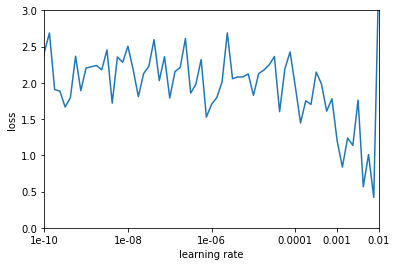

In [18]:
# if not os.path.exists('Best_rock_Model(ResNet).h5'):
if True:
    model = ResNet50Model()

    lr_begin = 1e-12
    lr_end = 1

    batch_size = 5
    train_g = Generator(x_train, y_train, batch_size)
    batch_num = len(x_train)//batch_size+1 # 一个epoch所含有的batch数量

    lr = lr_begin
    lr_multi = (lr_end/lr_begin)**(1/batch_num)
    lr_all = []
    loss_all = []
    acc_all = []

    optim = K.optimizers.Adamax(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=optim,
                      metrics=['accuracy'])
    cnt = 0
    for batch_data, batch_y in train_g:
        cnt+=1
        backend.set_value(model.optimizer.lr, lr)
        loss,acc = model.train_on_batch(batch_data,batch_y)
        lr_all.append(lr)
        loss_all.append(loss)
        acc_all.append(acc)
        lr = lr*lr_multi  

        if cnt == batch_num:
            break

    lr_all = np.array(lr_all)
    lr_best = lr_all[np.argmin(loss_all)]
    print('最优学习率为:',lr_best)
    plt.plot(np.log10(lr_all),loss_all)
    plt.xticks(np.log10([ 1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2,1e-1]), [ 1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2,1e-1])
    plt.xlim(np.log10(1e-10),np.log10(1e-2))
    plt.ylim(0,3)
    plt.ylabel('loss')
    plt.xlabel('learning rate')
    plt.savefig('find_lr_520.png',dpi  =100 )
    plt.show()

In [13]:
lr_best = 1e-3 # 还是肉眼手动根据绘图结果指定lr_best比较好一些，肉眼可以综合考虑学习率在训练时的稳定性

if os.path.exists('Best_rock_Model(ResNet).h5'):
    model_Best = 'Best_rock_Model(ResNet).h5'
    model = load_model(model_Best)
    optim = K.optimizers.Adamax(lr=1e-4)
else:
    model = ResNet50Model()
    optim = K.optimizers.Adamax(lr=lr_best)

# 定义学习率调整方案
def scheduler(epoch):
    lr = optim.lr.numpy()
    if epoch>=10:
        lr = 1e-4
    if epoch>=30:
        lr = 1e-6
    print(epoch, lr)
    return lr 
reduce_lr = K.callbacks.LearningRateScheduler(scheduler)

# 断点续训
checkpoint = ModelCheckpoint('Best_rock_Model(ResNet).h5', verbose=1, monitor='val_accuracy', 
                             save_best_only=True, mode='max')

# 指定模型的损失函数，优化器，衡量指标

model.compile(loss='categorical_crossentropy', optimizer=optim,
              metrics=['accuracy'])

# 模型训练
batch_size = 5
history = model.fit(Generator(x_train, y_train, batch_size),
              steps_per_epoch=len(x_train)//batch_size,
              epochs=50,
              validation_data=Generator(x_val, y_val, batch_size),
              validation_steps=len(x_val) // batch_size,
              callbacks=[checkpoint,reduce_lr])

D:\Application\Anaconda\envs\keras\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/50
0 0.001
95/95 [==============================] - 31s 331ms/step - loss: 1.6150 - accuracy: 0.4337 - val_loss: 0.2209 - val_accuracy: 0.5652

Epoch 00001: val_accuracy improved from -inf to 0.56522, saving model to Best_rock_Model(ResNet).h5
Epoch 2/50
1 0.001
95/95 [==============================] - 21s 218ms/step - loss: 0.6486 - accuracy: 0.7983 - val_loss: 3.6476 - val_accuracy: 0.5789

Epoch 00002: val_accuracy improved from 0.56522 to 0.57895, saving model to Best_rock_Model(ResNet).h5
Epoch 3/50
2 0.001
95/95 [==============================] - 19s 199ms/step - loss: 0.1789 - accuracy: 0.9597 - val_loss: 1.2536 - val_accuracy: 0.8158

Epoch 00003: val_accuracy improved from 0.57895 to 0.81579, saving model to Best_rock_Model(ResNet).h5
Epoch 4/50
3 0.001
95/95 [==============================] - 19s 200ms/step - loss: 0.0339 - accuracy: 0.9958 - val_loss: 0.0034 - val_accuracy: 0.8070

Epoch 00004: val_accuracy did not improve from 0.81579
Epoch 5/50
4 0.001
95/95 [=====

95/95 [==============================] - 19s 199ms/step - loss: 2.6064e-04 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.8509

Epoch 00038: val_accuracy did not improve from 0.86842
Epoch 39/50
38 1e-06
95/95 [==============================] - 19s 200ms/step - loss: 2.5939e-04 - accuracy: 1.0000 - val_loss: 1.5195e-04 - val_accuracy: 0.8333

Epoch 00039: val_accuracy did not improve from 0.86842
Epoch 40/50
39 1e-06
95/95 [==============================] - 19s 199ms/step - loss: 2.6061e-04 - accuracy: 1.0000 - val_loss: 2.3871 - val_accuracy: 0.8333

Epoch 00040: val_accuracy did not improve from 0.86842
Epoch 41/50
40 1e-06
95/95 [==============================] - 19s 199ms/step - loss: 2.6105e-04 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 0.8421

Epoch 00041: val_accuracy did not improve from 0.86842
Epoch 42/50
41 1e-06
95/95 [==============================] - 19s 200ms/step - loss: 2.6005e-04 - accuracy: 1.0000 - val_loss: 1.5248 - val_accuracy: 0.8333

Epoch 0

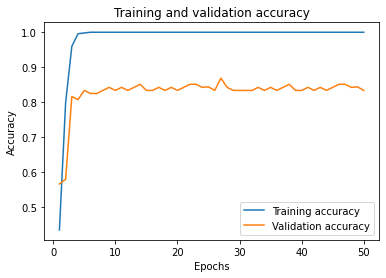

In [15]:
# 绘制训练精度和验证精度
history_dict = history.history
acc = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(acc)+1)


plt.plot(epochs, acc, label = 'Training accuracy')
plt.plot(epochs, val_accuracy, label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('seed_520_lr_ResNet.png',dpi=200) # 保存图片
plt.show()

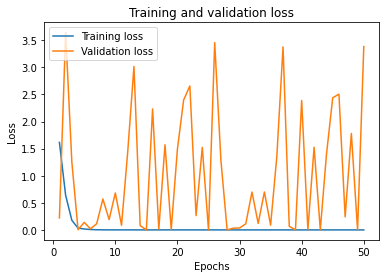

In [16]:
# 绘制训练损失和验证损失
history_dict = history.history
acc = history_dict['loss']
val_accuracy = history_dict['val_loss']

epochs = range(1, len(acc)+1)


plt.plot(epochs, acc, label = 'Training loss')
plt.plot(epochs, val_accuracy, label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 模型预测

In [30]:
# 载入图片,进行预测
r = './rock/1-1.bmp'
img = Image.open(r)
img = img.resize((224,224))
img = np.array(img)
img = img[:,:,:3]
img = imgsub(img)
img = np.expand_dims(img,axis = 0 )


if os.path.exists('Best_rock_Model(ResNet).h5'):
    model_Best = 'Best_rock_Model(ResNet).h5'
    model = load_model(model_Best)

res = model.predict(img)

# 预测结果
print('Results are',res)

Results are [[1.03532975e-05 9.21120261e-07 3.82140115e-06 9.99548256e-01
  5.89497540e-06 4.30419255e-04 2.79643530e-07]]


## 预测结果可视化

D:\Application\Anaconda\envs\keras\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


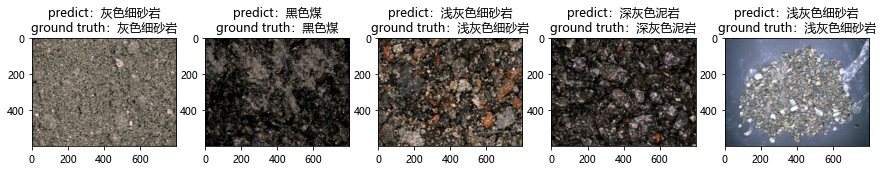

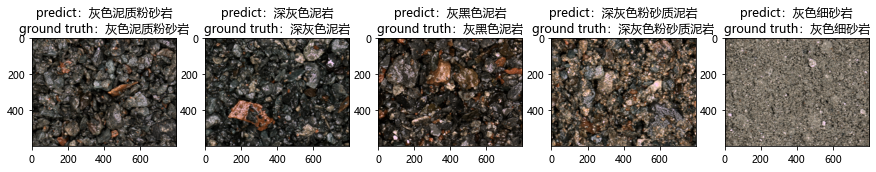

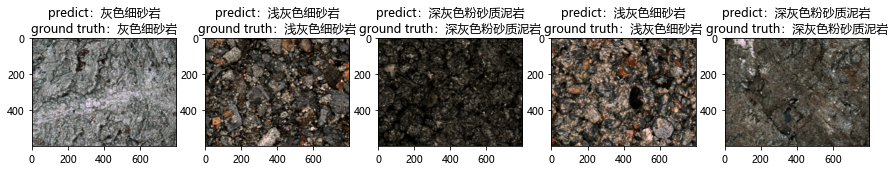

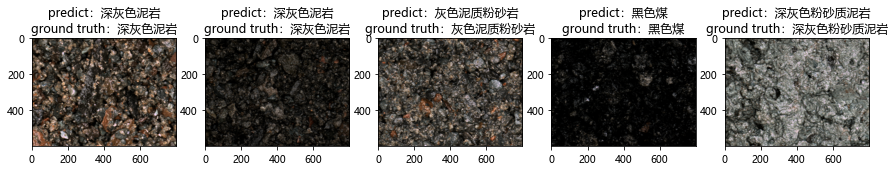

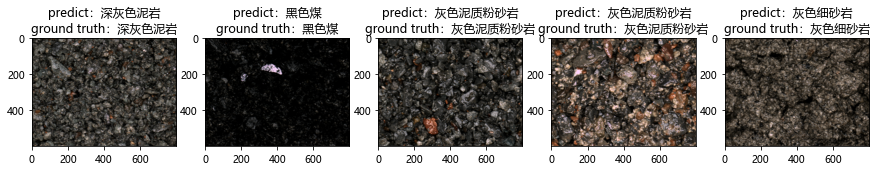

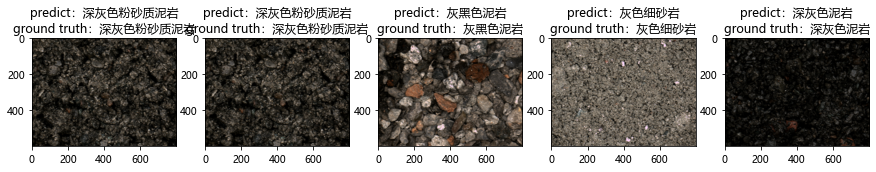

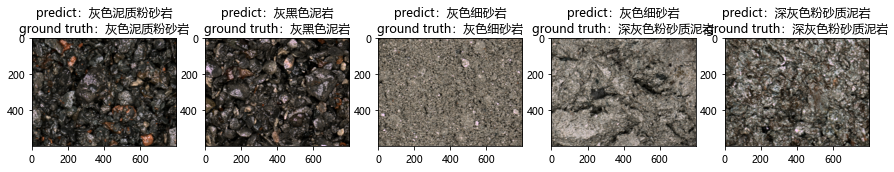

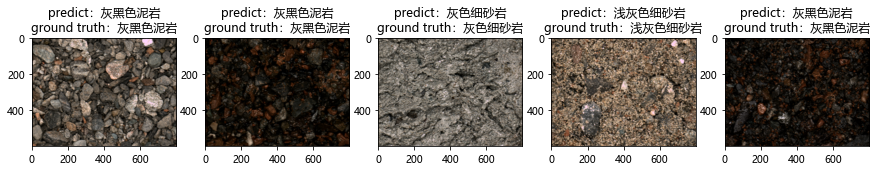

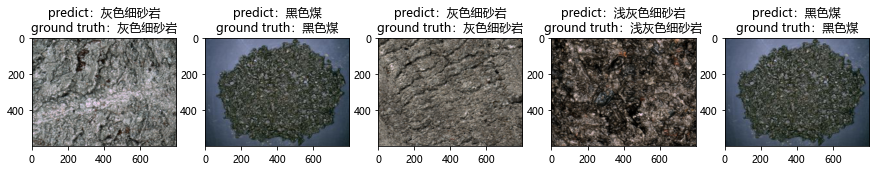

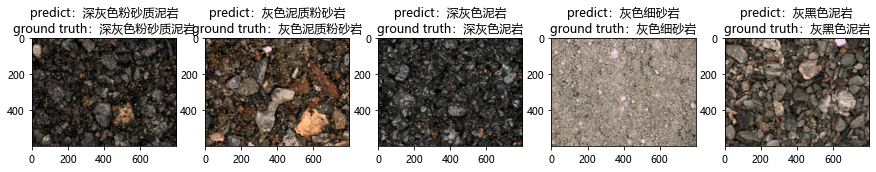

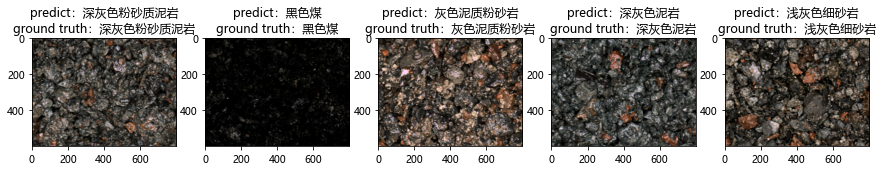

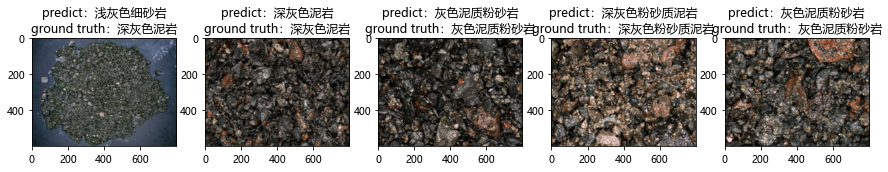

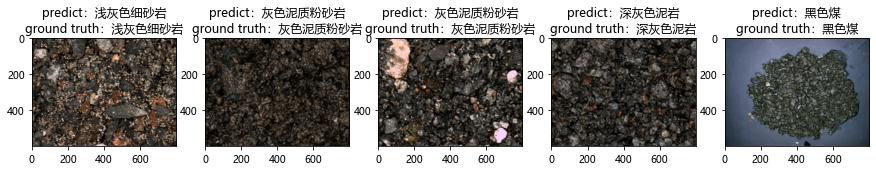

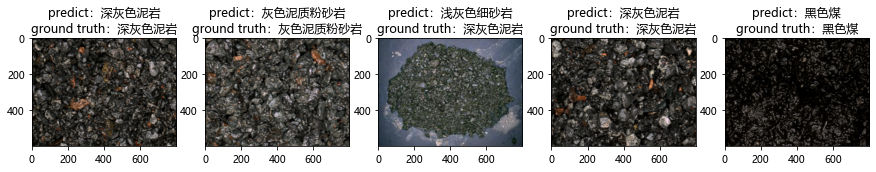

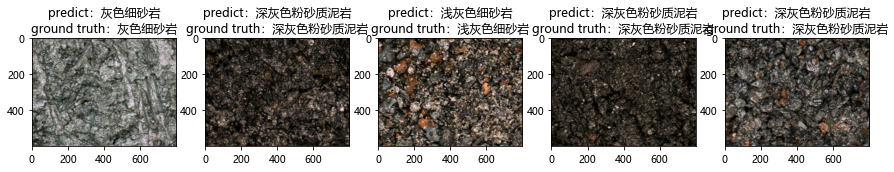

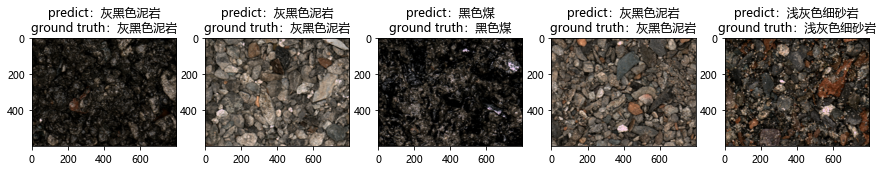

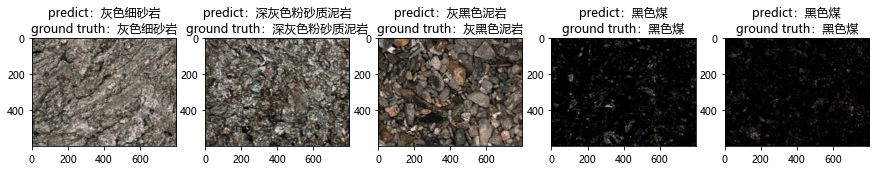

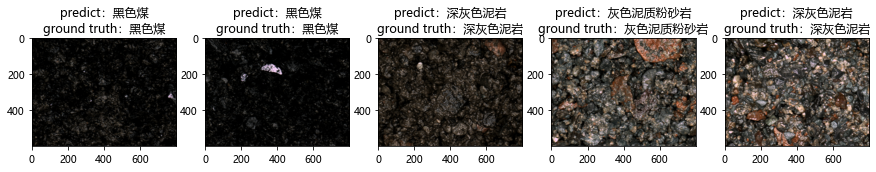

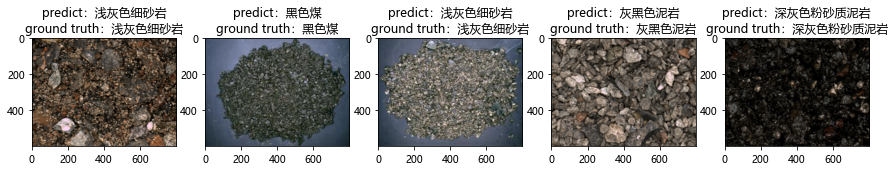

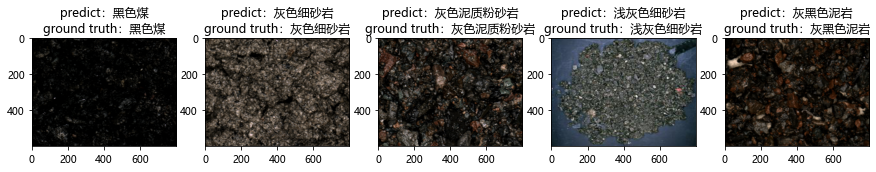

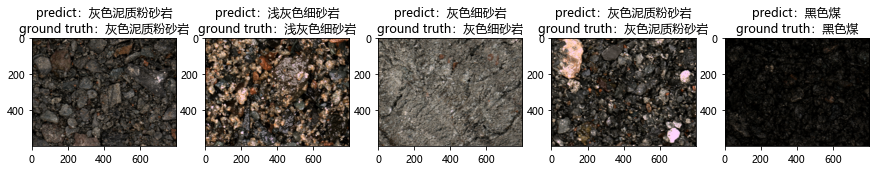

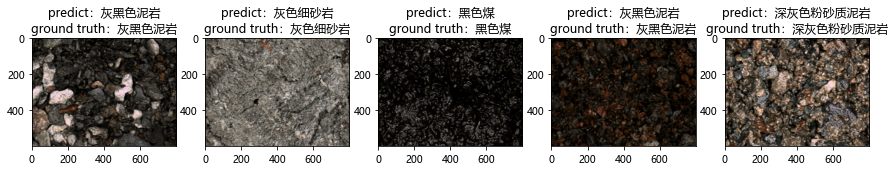

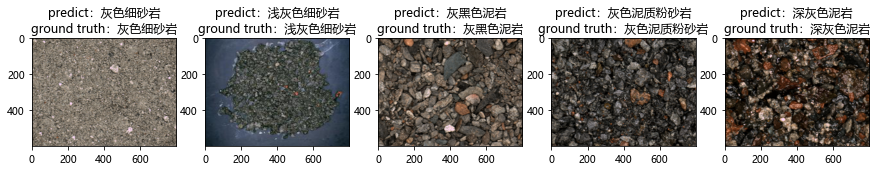

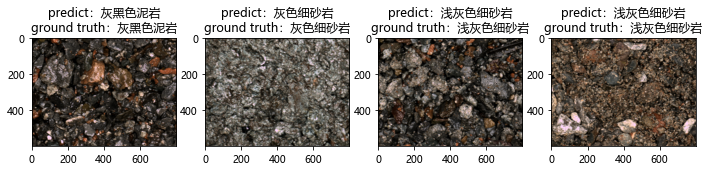

In [31]:
# plt绘图中显示中文和符号
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False 

df_label = pd.read_csv('label_new.csv')

# fig = plt.figure(figsize = (15,4*315))
for i in range(len(x_val)):
    img_show_name = x_val[i]
    img_show_num = os.path.split(img_show_name)[-1].split('-')[0]
    img_show_num = int(img_show_num)
    
    # 利用样本编号（文件名,x_val）与样本类别的对应关系
    label_show_chinese = df_label['样本类别'][df_label['样本编号']==img_show_num]
    label_show_chinese = label_show_chinese.iloc[0]
    
    img = Image.open(img_show_name).convert('RGB')
    img = img.resize((224,224))
    img = np.array(img)
    img_plot = img.copy()
    
    img = imgsub(img)
    img = np.expand_dims(img,axis = 0 )
    predict = model.predict(img)
    predict_num = np.argmax(predict)
    predict_chinese = df_label['样本类别'][df_label['类别标签']==predict_num].iloc[0]# 得到预测结果的中文
    
    #ax = fig.add_subplot(315,5,i+1)
    if i%5==0:
        plt.figure(figsize = (15,3))
    plt.subplot(1,5,i%5+1)
    img_plot = Image.fromarray(img_plot).resize((800,600))
    img_plot = np.array(img_plot)
    plt.imshow(img_plot)
    plt.title(f'predict：{predict_chinese}\nground truth：{label_show_chinese}')
    